# Music Lyrics Through the Years

#### Import (possibly) necessary libraries

In [275]:
import pandas as pd; pd.options.display.max_rows = 200
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

import re
from unicodedata import normalize

import requests as rq
from bs4 import BeautifulSoup as bs
from selenium import webdriver

import pickle
import gzip

from functions.webscraping import *

import json

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Scrape song title and artist

In [2]:
%%time

# list of unique songs in top 10 between 1960 and 2019
all_top10s = [
    yearly_top10s(f'https://top40weekly.com/{year}-all-charts/') for year in range(1960,2020)
]

len(all_top10s)

CPU times: user 14.3 s, sys: 172 ms, total: 14.4 s
Wall time: 1min 32s


60

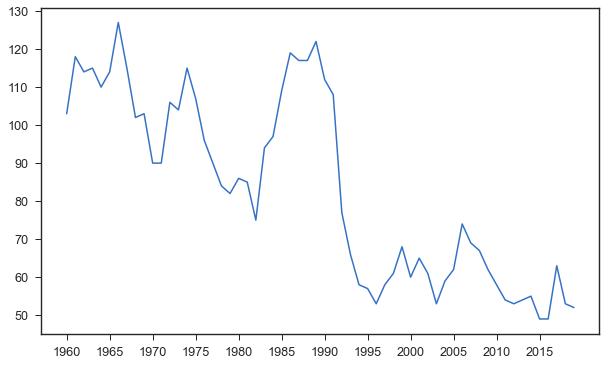

In [3]:
# graph number of unique songs per year
plt.figure(figsize=(10,6))
plt.plot([len(year) for year in all_top10s])
plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5))
plt.show()

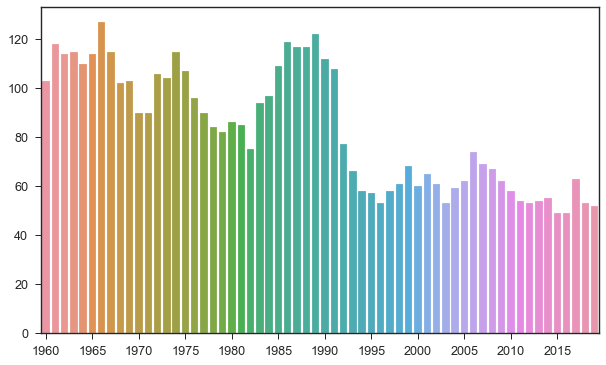

In [4]:
# graph number of unique songs per year
plt.figure(figsize=(10,6))
sns.barplot(x=[year for year in range(1960,2020)], y=[len(year) for year in all_top10s])
plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5))
plt.show()

In [5]:
# number of songs
sum([len(year) for year in all_top10s])

4996

- Since some songs may be within the top 10 in two different years, I need to remove those from the list.

In [6]:

temp_dict = {}

for i,year in enumerate(all_top10s):
    for song in year:
        if song in temp_dict:
            print(song)
            all_top10s[i].remove(song)
            
        else:
            temp_dict[song] = 1
            
len(temp_dict)

('SAILOR (Your Home Is the Sea)', 'Lolita')
('YOU’RE SIXTEEN', 'Johnny Burnette')
('MANY TEARS AGO', 'Connie Francis')
('NORTH TO ALASKA', 'Johnny Horton')
('THE TWIST', 'Chubby Checker')
('WONDERLAND BY NIGHT', 'Bert Kaempfert')
('A THOUSAND STARS', 'Kathy Young and the Innocents')
('LAST DATE', 'Floyd Cramer')
('EXODUS', 'Ferrante and Teicher')
('GOODBYE CRUEL WORLD', 'James Darren')
('RUN TO HIM', 'Bobby Vee')
('WALK ON BY', 'Leroy Van Dyke')
('THE TWIST', 'Chubby Checker')
('HAPPY BIRTHDAY, SWEET SIXTEEN', 'Neil Sedaka')
('PEPPERMINT TWIST (Part 1)', 'Joey Dee and the Starliters')
('THE LION SLEEPS TONIGHT', 'The Tokens')
('HOTEL HAPPINESS', 'Brook Benton')
('ZIP-A-DEE DOO-DAH', 'Bob B')
('LIMBO ROCK', 'Chubby Checker')
('GO AWAY LITTLE GIRL', 'Steve Lawrence')
('BOBBY’S GIRL', 'Marcie Blane')
('TALK BACK TREMBLING LIPS', 'Johnny Tillotson')
('DOMINIQUE', 'The Singing Nun')
('POPSICLES AND ICICLES', 'The Murmaids')
('SINCE I FELL FOR YOU', 'Lenny Welch')
('FORGET HIM', 'Bobby Rydel

4118

In [7]:
# number of unique songs
sum([len(year) for year in all_top10s])

4555

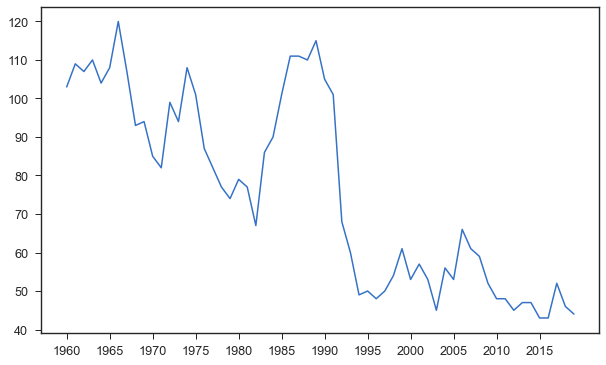

In [8]:
plt.figure(figsize=(10,6))
plt.plot([len(year) for year in all_top10s])
plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5))
plt.show()

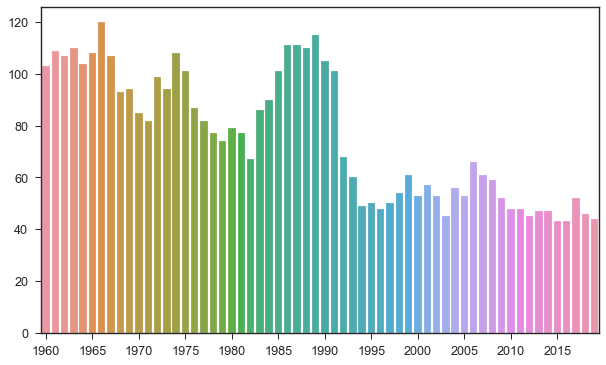

In [9]:
plt.figure(figsize=(10,6))
sns.barplot(x=[year for year in range(1960,2020)], y=[len(year) for year in all_top10s])
plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5))
plt.show()

## Scrape lyrics

In [10]:
# parse personal api keys
with open('data/api_keys.json', 'r') as json_file:
    creds = json.load(json_file)

# set the credentials based on the credentials file
client_id = creds['client_id']
client_secret = creds['client_secret']
access_token = creds['access_token']

In [11]:
%%time

top10s = []

for i,year in enumerate(all_top10s):
    
    print('\n' + str(i+1960))
    
    for song in year:
        
        song_dict = {}
        song_dict['year'] = i+1960
        song_dict['title'] = song[0]
        song_dict['artist'] = song[1]
        search_term = f'{song[0]} {song[1]}'
        
        try:
            song_dict['lyrics'] = lyrics_grabber(access_token, search_term)
            
        except:
            try:
                search_term = f"{re.match('[A-Z ]+', song[0]).group()} {' '.join(song[1].split()[:2])}"
                song_dict['lyrics'] = lyrics_grabber(access_token, search_term)
                                                                                 
            except:
                print(f'  {search_term}')
                song_dict['lyrics'] = np.nan
                                                                                 
        top10s.append(song_dict)
        
len(top10s)


1960

1961

1962

1963
  (Down At) PAPA JOE’S The Dixiebelles

1964

1965

1966

1967
  AN OPEN LETTER TO MY TEENAGE SON Victor Lundberg

1968

1969

1970
  MIDNIGHT COWBOY Ferrante and

1971

1972
  JUNGLE FEVER The Chakachas

1973

1974

1975

1976

1977

1978

1979

1980

1981

1982

1983

1984

1985

1986

1987

1988

1989

1990

1991

1992

1993

1994

1995

1996

1997

1998

1999

2000

2001

2002

2003

2004

2005

2006

2007

2008

2009

2010

2011

2012

2013

2014

2015

2016
  JUJU ON DAT BEAT  Zayion McCall

2017

2018

2019
CPU times: user 5min 33s, sys: 14.6 s, total: 5min 47s
Wall time: 1h 55min 43s


4555

In [12]:
df = pd.DataFrame(top10s)
df.shape

(4555, 4)

In [13]:
df.head()

,year,title,artist,lyrics
0,1960,PAPER ROSES,Anita Bryant,I realize the way your eyes deceived me\nWith ...
1,1960,HE’LL HAVE TO GO,Jim Reeves,[Verse 1]\nPut your sweet lips a little closer...
2,1960,O DIO MIO,Annette,"[Strofa 1]\nE un giorno lui mi disse: ""Nei tuo..."
3,1960,YOGI,The Ivy Three,[Chorus]\nI got bitches on the side but she st...
4,1960,KIDDIO,Brook Benton,"I told you, baby, how I feel\nOne word can clo..."


In [14]:
df.tail()

,year,title,artist,lyrics
4550,2019,TALK,Khalid,[Chorus]\nCan we just talk? Can we just talk?\...
4551,2019,MIDDLE CHILD,J,"[Intro]\nYou good, T-Minus?\n\n[Refrain]\nNigg..."
4552,2019,I DON’T CARE,Ed Sheeran,[Verse 1: Ed Sheeran]\nI'm at a party I don't ...
4553,2019,TRUTH HURTS,Lizzo,[Intro]\nWhy men great 'til they gotta be grea...
4554,2019,PANINI,Lil Nas X,[Intro: Nessly]\nD-D-Daytrip took it to ten (H...


### Remove brackets and words contained within
- These tend to be denoting verse from chorus (or something similar) or other non-lyric words.

In [184]:
df['lyrics'] = df.lyrics.map(remove_brackets)

### Save/Load

In [511]:
# uncomment to save
with gzip.open('data/lyrics_df.pkl', 'wb') as goodbye:
    pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/lyrics_df.pkl', 'rb') as hello:
#     df = pickle.load(hello)

## Rescrapes

### 1960

In [42]:
# rescrape
df.loc[3, 'lyrics'] = rescrape('http://www.songlyrics.com/the-larks/jerk-lyrics/',
                                 name='div', attrs={'id': 'lyrics_text'})
df.loc[51, 'lyrics'] = lyrics_grabber(access_token, search_term="because they're young duane eddy and the rebels")

soup = soupify('https://www.stlyrics.com/lyrics/heartsinatlantis/themefromasummerplace.htm')
df.loc[57, 'lyrics'] = '\n'.join(
    [line.contents[0] for line in soup.find_all('div', class_='highlight') if line.contents]
)

df.loc[101, 'lyrics'] = rescrape('https://mojim.com/usy155738x2x2.htm',
                                 name='dl', attrs={'id': 'fsZx1'})

### 1961

In [103]:
# rescrape
soup = soupify('https://www.flashlyrics.com/lyrics/ferrante-and-teicher/tonight-12')
df.loc[123, 'lyrics'] = '\n'.join(
    [line.contents[0] for line in soup.find('div', attrs={'class': 'main-panel-content'}).find_all('span')
     if line.contents]
)

df.loc[192, 'lyrics'] = lyrics_grabber(access_token, 'arthur lyman yellow bird')
df.loc[211, 'lyrics'] = rescrape('https://www.songfacts.com/lyrics/dick-dee-dee/the-mountains-high',
                                 name='div', attrs={'class': 'inner'})

In [146]:
# instrumentals
df.loc[113, 'lyrics'] = np.nan
df.loc[142, 'lyrics'] = np.nan
df.loc[159, 'lyrics'] = np.nan
df.loc[191, 'lyrics'] = np.nan

In [132]:
# remove lines
df.loc[131, 'lyrics'] = remove_n_lines(4, df.loc[131, 'lyrics'])
df.loc[164, 'lyrics'] = remove_n_lines(3, df.loc[164, 'lyrics'])
df.loc[168, 'lyrics'] = remove_n_lines(7, df.loc[168, 'lyrics'])

In [140]:
# update artist
df.loc[164, 'artist'] = 'The String-A-Longs'

### 1962

In [166]:
# rescrape
df.loc[310, 'lyrics'] = lyrics_grabber(access_token, 'joey dee shout')

In [167]:
# instrumentals
df.loc[212, 'lyrics'] = np.nan
df.loc[215, 'lyrics'] = np.nan
df.loc[223, 'lyrics'] = np.nan
df.loc[254, 'lyrics'] = np.nan
df.loc[266, 'lyrics'] = np.nan
df.loc[268, 'lyrics'] = np.nan
df.loc[297, 'lyrics'] = np.nan

### 1963

In [196]:
# rescrape
df.loc[348, 'lyrics'] = lyrics_grabber(access_token, 'fingertips stevie')

In [187]:
# instrumentals
df.loc[338, 'lyrics'] = np.nan
df.loc[340, 'lyrics'] = np.nan
df.loc[356, 'lyrics'] = np.nan
df.loc[415, 'lyrics'] = np.nan
df.loc[421, 'lyrics'] = np.nan
df.loc[423, 'lyrics'] = np.nan

In [197]:
# remove lines
df.loc[368, 'lyrics'] = remove_n_lines(2, df.loc[368, 'lyrics'])
df.loc[388, 'lyrics'] = remove_n_lines(2, df.loc[388, 'lyrics'])

In [193]:
# remove duplicate
df.drop(index=427, inplace=True)

### 1964

In [205]:
# rescrape
df.loc[440, 'lyrics'] = lyrics_grabber(access_token, 'roy orbison pretty woman')
df.loc[463, 'lyrics'] = lyrics_grabber(access_token, 'dancing in the street martha')
df.loc[476, 'lyrics'] = lyrics_grabber(access_token, 'summer song chad')
df.loc[480, 'lyrics'] = rescrape('http://www.songlyrics.com/the-larks/jerk-lyrics/',
                                 name='p', attrs={'class': 'songLyricsV14 iComment-text'})

In [230]:
# instrumentals
df.loc[499, 'lyrics'] = np.nan
df.loc[521, 'lyrics'] = np.nan
df.loc[532, 'lyrics'] = np.nan

In [211]:
# update artist name
df.loc[476, 'artist'] = 'Chad and Jeremy'

### 1965

In [240]:
# rescrape
df.loc[558, 'lyrics'] = lyrics_grabber(access_token, 'nowhere to run martha')
df.loc[582, 'lyrics'] = lyrics_grabber(access_token, "Papa’s Got a Brand New Bag (Part 1)")
df.loc[583, 'lyrics'] = lyrics_grabber(access_token, "I Can’t Help Myself (Sugar Pie, Honey Bunch)")
df.loc[597, 'lyrics'] = lyrics_grabber(access_token, 'i got you babe')

In [247]:
# instrumentals
df.loc[578, 'lyrics'] = np.nan
df.loc[585, 'lyrics'] = np.nan

In [245]:
# remove duplicate
df.drop(index=587, inplace=True)

### 1966

In [254]:
# rescrape
df.loc[650, 'lyrics'] = lyrics_grabber(access_token, 'california dreamin')
df.loc[665, 'lyrics'] = lyrics_grabber(access_token, 'lady godiva peter')
df.loc[665, 'lyrics'] = lyrics_grabber(access_token, 'lady godiva peter')
df.loc[702, 'lyrics'] = lyrics_grabber(access_token, 'kicks paul revere')

In [262]:
# remove duplicate
df.drop(index=740, inplace=True)

### 1967

In [281]:
# rescrape
df.loc[845, 'lyrics'] = rescrape('http://www.songlyrics.com/victor-lundberg/an-open-letter-to-my-teenage-son-lyrics/',
                                 name='p', attrs={'class': 'songLyricsV14 iComment-text'})

### 1968

In [287]:
# rescrape
df.loc[900, 'lyrics'] = lyrics_grabber(access_token, 'mrs. robinson')

In [295]:
# instrumentals
df.loc[904, 'lyrics'] = np.nan
df.loc[909, 'lyrics'] = np.nan
df.loc[927, 'lyrics'] = np.nan
df.loc[937, 'lyrics'] = np.nan
df.loc[945, 'lyrics'] = np.nan

### 1969

In [300]:
# rescrape
df.loc[986, 'lyrics'] = lyrics_grabber(access_token, 'i want you back the jackson 5')
df.loc[1008, 'lyrics'] = lyrics_grabber(access_token, 'boxer simon garfunkel')

In [307]:
# instrumentals
df.loc[1012, 'lyrics'] = np.nan
df.loc[1015, 'lyrics'] = np.nan
df.loc[1022, 'lyrics'] = np.nan

In [302]:
# update artist
df.loc[986, 'artist'] = 'The Jackson 5'
df.loc[989, 'artist'] = 'Blue Swede'

### 1970

In [312]:
# rescrape
df.loc[1068, 'lyrics'] = lyrics_grabber(access_token, 'bridge over troubled water simon garfunkel')
df.loc[1085, 'lyrics'] = lyrics_grabber(access_token, 'abc the jackson 5')

In [318]:
# update artist
df.loc[1085, 'artist'] = 'The Jackson 5'
df.loc[1092, 'artist'] = 'The Jackson 5'

### 1971

In [320]:
# instrumentals
df.loc[1182, 'lyrics'] = np.nan

### 1972

In [323]:
# instrumentals
df.loc[1182, 'lyrics'] = np.nan
df.loc[1253, 'lyrics'] = np.nan
df.loc[1292, 'lyrics'] = np.nan

# edge case; non-lyric song
df.loc[1252, 'lyrics'] = np.nan

### 1973

In [327]:
# rescrape
df.loc[1321, 'lyrics'] = lyrics_grabber(access_token, 'neither one of us gladys knight')
df.loc[1324, 'lyrics'] = lyrics_grabber(access_token, 'The Morning After (Theme From The Poseidon Adventure)')

In [338]:
# instrumentals
df.loc[1385, 'lyrics'] = np.nan

# edge case; non-lyric song
df.loc[1398, 'lyrics'] = np.nan

In [336]:
# remove lines
df.loc[1386, 'lyrics'] = remove_n_lines(2, df.loc[1386, 'lyrics'])

### 1974

In [342]:
# rescrape
df.loc[1449, 'lyrics'] = lyrics_grabber(access_token, 'jet wings')
df.loc[1453, 'lyrics'] = lyrics_grabber(access_token, 'band on the run wings')
df.loc[1488, 'lyrics'] = lyrics_grabber(access_token, 'jungle boogie')
df.loc[1514, 'lyrics'] = lyrics_grabber(access_token, 'hollywood swinging')

In [347]:
# instrumentals
df.loc[1440, 'lyrics'] = np.nan
df.loc[1476, 'lyrics'] = np.nan
df.loc[1479, 'lyrics'] = np.nan

In [351]:
# remove duplicate
df.drop(index=1481, inplace=True)

### 1975

In [363]:
# rescrape
df.loc[1577, 'lyrics'] = lyrics_grabber(access_token, 'love rollercoaster ohio players')
df.loc[1587, 'lyrics'] = lyrics_grabber(access_token, 'yesterday carpenters')
df.loc[1596, 'lyrics'] = lyrics_grabber(access_token, 'philadelphia freedom elton john')
df.loc[1622, 'lyrics'] = lyrics_grabber(access_token, 'fire ohio players')

In [368]:
# instrumentals
df.loc[1594, 'lyrics'] = np.nan

### 1976

In [380]:
# rescrape
df.loc[1625, 'lyrics'] = lyrics_grabber(access_token, 'sara smile hall oates')
df.loc[1652, 'lyrics'] = lyrics_grabber(access_token, 'more more more andrea true')
df.loc[1664, 'lyrics'] = lyrics_grabber(access_token, 'sing a song earth')
df.loc[1667, 'lyrics'] = lyrics_grabber(access_token, 'muskrat love')
df.loc[1690, 'lyrics'] = lyrics_grabber(access_token, 'disco duck rick dees')

In [394]:
# instrumentals
df.loc[1639, 'lyrics'] = np.nan
df.loc[1681, 'lyrics'] = np.nan

### 1977

In [402]:
# rescrape
df.loc[1736, 'lyrics'] = lyrics_grabber(access_token, 'jet airliner steve miller')
df.loc[1775, 'lyrics'] = lyrics_grabber(access_token, 'eagle steve miller')

In [408]:
# instrumentals
df.loc[1784, 'lyrics'] = np.nan

In [399]:
# remove lines
df.loc[1720, 'lyrics'] = remove_n_lines(2, df.loc[1720, 'lyrics'])

### 1978

In [412]:
# rescrape
df.loc[1844, 'lyrics'] = lyrics_grabber(access_token, 'ymca village people')

In [413]:
# instrumentals
df.loc[1827, 'lyrics'] = np.nan

### 1979

In [421]:
# instrumentals
df.loc[1929, 'lyrics'] = np.nan
df.loc[1932, 'lyrics'] = np.nan

### 1980

In [426]:
# rescrape
df.loc[1961, 'lyrics'] = lyrics_grabber(access_token, 'another brick in the wall')

In [429]:
# remove lines
df.loc[1967, 'lyrics'] = remove_n_lines(3, df.loc[1967, 'lyrics'])
df.loc[2013, 'lyrics'] = remove_n_lines(3, df.loc[2013, 'lyrics'])

### 1981

In [438]:
# remove lines
df.loc[2027, 'lyrics'] = remove_n_lines(6, df.loc[2027, 'lyrics'])

In [440]:
# instrumentals
df.loc[2038, 'lyrics'] = np.nan

### 1982

In [443]:
# rescrape
df.loc[2117, 'lyrics'] = lyrics_grabber(access_token, 'rock this town stray cats')
df.loc[2130, 'lyrics'] = lyrics_grabber(access_token, 'crimson and clover')

In [451]:
# instrumentals
df.loc[2153, 'lyrics'] = np.nan
df.loc[2160, 'lyrics'] = np.nan

### 1983

In [458]:
# rescrape
df.loc[2237, 'lyrics'] = lyrics_grabber(access_token, 'sweet dreams eurythmics')

In [454]:
# remove lines
df.loc[2179, 'lyrics'] = remove_n_lines(8, df.loc[2179, 'lyrics'])

In [456]:
# remove duplicate
df.drop(index=2205, inplace=True)

### 1984

In [462]:
# rescrape
df.loc[2266, 'lyrics'] = lyrics_grabber(access_token, 'state of shock jacksons')
df.loc[2266, 'lyrics'] = lyrics_grabber(access_token, 'state of shock jacksons')

### 1985

In [466]:
# rescrape
df.loc[2309, 'lyrics'] = lyrics_grabber(access_token, 'the warrior scandal')

In [473]:
# instrumentals
df.loc[2358, 'lyrics'] = np.nan
df.loc[2405, 'lyrics'] = np.nan

In [471]:
# remove lines
df.loc[2385, 'lyrics'] = remove_n_lines(1, df.loc[2385, 'lyrics'])

### 1986

In [485]:
# rescrape
df.loc[2501, 'lyrics'] = lyrics_grabber(access_token, 'your wildest dreams')

### 1987

In [479]:
# rescrape
df.loc[2557, 'lyrics'] = lyrics_grabber(access_token, 'the one i love rem')
df.loc[2663, 'lyrics'] = lyrics_grabber(access_token, 'got the look prince')

In [491]:
# instrumentals
df.loc[2646, 'lyrics'] = np.nan

In [488]:
# update artist
df.loc[2557, 'artist'] = 'R.E.M.'

### 1988

In [495]:
# rescrape
df.loc[2678, 'lyrics'] = lyrics_grabber(access_token, "she's like the wind patrick swayze")

### 1989

In [502]:
# rescrape
df.loc[2862, 'lyrics'] = lyrics_grabber(access_token, 'friends jody watley')

### 1990

In [507]:
# remove lines
df.loc[2917, 'lyrics'] = remove_n_lines(3, df.loc[2917, 'lyrics'])

### 1991 - 1995

In [519]:
# rescrape
df.loc[3280, 'lyrics'] = lyrics_grabber(access_token, "gangsta's paradise coolio")

### 1996

In [527]:
# rescrape
df.loc[3371, 'lyrics'] = lyrics_grabber(access_token, 'nobody keith sweat')

In [523]:
# remove lines
df.loc[3324, 'lyrics'] = remove_n_lines(9, df.loc[3324, 'lyrics'])

In [526]:
# instrumentals
df.loc[3365, 'lyrics'] = np.nan

In [525]:
# remove duplicate
df.drop(index=3331, inplace=True)

### 1997

In [555]:
# rescrape
df.loc[3374, 'lyrics'] = lyrics_grabber(access_token, 'mmmbop')
df.loc[3384, 'lyrics'] = lyrics_grabber(access_token, 'feel so good ma$e')
df.loc[3395, 'lyrics'] = lyrics_grabber(access_token, 'gotham city r. kelly')
df.loc[3411, 'lyrics'] = lyrics_grabber(access_token, 'CAN’T NOBODY HOLD ME DOWN')

### 1998-1999

In [556]:
# rescrape
df.loc[3493, 'lyrics'] = lyrics_grabber(access_token, 'lost in you garth')
df.loc[3512, 'lyrics'] = lyrics_grabber(access_token, 'smooth santana')

### 2000

In [561]:
df[df.year == 2000]

,year,title,artist,lyrics
3537,2000,MUSIC,Madonna,"Hey Mr. DJ, put a record on\nI wanna dance wit..."
3538,2000,CASE OF THE EX (WHATCHA GONNA DO),Mya,I wanna follow where she goes\nI think about h...
3539,2000,AULD LANG SYNE,Kenny G,"""The first words I spoke in the original phono..."
3540,2000,I WANNA KNOW,Joe,"Yeah, oh yeah\nAlright, oh, oh, oh\n\n\nIt's a..."
3541,2000,"INDEPENDENT WOMEN, PART I",Destiny,"Tracklist1. Empress Of - ""Make Up""\n2. HONNE -..."
3542,2000,GET IT ON TONITE,Montell Jordan,"Oh, ooh wee oh, oh\n\n\nWhen I'm lookin' at yo..."
3543,2000,SAY MY NAME,Destiny,"Darkchild '99\n\n\nSay my name, say my name\nI..."
3544,2000,IT’S GONNA BE ME,NSYNC,It's gonna be me\nOooh yeah\n\n\nYou might've ...
3545,2000,WIFEY,Next,You never try me\nAlways stood right by me\nMa...
3546,2000,IF YOU’RE GONE,matchbox twenty,I think I've already lost you\nI think you're ...


In [559]:
df.loc[3512, 'lyrics'] = lyrics_grabber(access_token, 'smooth santana')

In [560]:
print(df.loc[3512, 'lyrics'])

[Verse 1]
Man, it's a hot one
Like seven inches from the midday sun
I hear you whisper and the words melt everyone
But you stay so cool
My muñequita, my Spanish Harlem Mona Lisa
You're my reason for reason, the step in my groove

[Bridge]
And if you say this life ain't good enough
I would give my world to lift you up
I could change my life to better suit your mood
Because you're so smooth

[Chorus]
And it's just like the ocean under the moon
It's the same as the emotion that I get from you
You got the kind of loving that can be so smooth
Gimme your heart, make it real, or else forget about it

[Verse 2]
I'll tell you one thing
If you would leave it would be a crying shame
In every breath and every word
I hear your name calling me out
Out from the barrio, you hear my rhythm on the radio
You feel the turning of the world so soft and slow
Turning you round and round

[Bridge]
And if you say this life ain't good enough
I would give my world to lift you up
I could change my life to better s

### 1998

In [331]:
df.loc[1324, 'lyrics'] = lyrics_grabber(access_token, 'The Morning After (Theme From The Poseidon Adventure)')

In [335]:
remove_n_lines(2, df.loc[1386, 'lyrics'])

"Can't say  found out\n can't tell you\nWhat's all about\nDon't know who does\n tell you to\nBeware, my love\nBeware, my love\nBeware, my love\nBeware, my love\nBeware, my love\nBeware, my love\nOh, oh, oh\nNo, no, no\nI must be wrong, baby, yeah\nBut I don't believe that he's the one\nBut if you insist\nI must be wrong, I must be wrong\nI have to leave\nAnd when I'm gone\nI'll leave my message in my song\nThat's right\nBeware, my love\nHe'll bowl you over\nBeware, my love\nBefore you're much older\nHe'll sweep you up under his carpet\nYou'd be in luck if you could stop it\nCome on, now\nWell, he'll wear you out\nAnd in a miniute\nYou'll hear a shout\nAnd then you'll be in it\nSo, so beware my love\n'cause he'll take you under\nBeware, my love\nThe sound of his thunder;\nCan't say  found out\nI tell you to\nBeware, my love\nBeware, my love\nBeware, my love\nBeware, my love"

In [246]:
df[df.artist == 'The Larks']

,year,title,artist,lyrics
480,1964,THE JERK,The Larks,"Girl, hey what's that you're doin'?\n\nGirl, g..."


In [225]:
rescrape('http://www.songlyrics.com/the-larks/jerk-lyrics/',
                                 soup.find('p', attrs={'class': 'songLyricsV14 iComment-text'}).contents)

"Girl, hey what's that you're doin'?\n\nGirl, girl, what's that you're doin'?\n\nYou've got to show me the steps to it\n\nSomehow I'm gonna learn how to do it\n\nDo the jerk, hey\n\nDo the jerk, girl, come on and work, hey\n\nDo the jerk\n\nGirl, how do you move your hips so fine?\n\nGirl (come on time)\n\nWork it out, right on time\n\nEverybodys got the beat, hey look at me\n\nDoin' the jerk, yeah, now watch me work\n\nGirl, now do the jerk, hey, do the jerk\n\nGo on and soul, soul, soul, soul\n\nSoul everybody now, soul, soul, soul\n\nYou don't know how to do it?\n\nCome on, gonna teach it to ya'\n\nI'm doin the jerk, yeah\n\nWatch me work, girl, now\n\nDo the jerk, come on time\n\nDo the jerk, let me see you work\n\nDo the jerk, everbody\n\nDo the jerk, come on now\n\nDo the jerk, with alittle bit of soul\n\nDo the jerk, show em girl\n\nDo the jerk, work, work, work,\n\nDo the jerk, come on girl\n\nDo the jerk, listen everybody\n\nDo the jerk, I like the way you work\n\nDo the jerk,

In [214]:
soup = soupify('http://www.songlyrics.com/the-larks/jerk-lyrics/')

In [224]:
soup.find('p', attrs={'class': 'songLyricsV14 iComment-text'}).contents

["Girl, hey what's that you're doin'?",
 <br/>,
 "\nGirl, girl, what's that you're doin'?",
 <br/>,
 "\nYou've got to show me the steps to it",
 <br/>,
 "\nSomehow I'm gonna learn how to do it",
 <br/>,
 '\nDo the jerk, hey',
 <br/>,
 '\nDo the jerk, girl, come on and work, hey',
 <br/>,
 '\nDo the jerk',
 <br/>,
 '\n',
 <br/>,
 '\nGirl, how do you move your hips so fine?',
 <br/>,
 '\nGirl (come on time)',
 <br/>,
 '\nWork it out, right on time',
 <br/>,
 '\nEverybodys got the beat, hey look at me',
 <br/>,
 "\nDoin' the jerk, yeah, now watch me work",
 <br/>,
 '\nGirl, now do the jerk, hey, do the jerk',
 <br/>,
 '\n',
 <br/>,
 '\nGo on and soul, soul, soul, soul',
 <br/>,
 '\nSoul everybody now, soul, soul, soul',
 <br/>,
 "\nYou don't know how to do it?",
 <br/>,
 "\nCome on, gonna teach it to ya'",
 <br/>,
 "\nI'm doin the jerk, yeah",
 <br/>,
 '\nWatch me work, girl, now',
 <br/>,
 '\nDo the jerk, come on time',
 <br/>,
 '\nDo the jerk, let me see you work',
 <br/>,
 '\nDo the je

In [155]:
'\n'.join(
    [line.strip() for line in soup.find('div', attrs={'class': 'inner'}).contents
     if isinstance(line, str) if line.strip()]
)

"Yeah, yeah, yeah\nThe mountain's high\nAnd the valley's so deep\nCan't get across\nTo the other side\nDon't you give up, baby\nDon't you cry\nDon't you give up til\nI reach the other side\nI was lonely, baby\nI couldn't sleep\nThe night they took you\nFrom my side\nI was a lonely soul\nUntil you became my goal\nAnd then I saw the spark of love\nAnd then the stars fell\nFrom up above, oh, yeah\nI know someday\nWe will meet again\nBut I don't know exactly\nWhere or when\nBut, baby, if fate has its way\nWe'll meet again some other day\nThe mountain's high\nAnd the valley's so deep\nCan't get across\nTo the other side\nDon't you give up, baby\nDon't you cry\nDon't you give up til\nI reach the other side"

In [154]:
soup.find('div', attrs={'class': 'inner'}).contents

['\n                                                  Yeah, yeah, yeah',
 <br/>,
 <br/>,
 "The mountain's high",
 <br/>,
 "And the valley's so deep",
 <br/>,
 "Can't get across",
 <br/>,
 'To the other side',
 <br/>,
 <br/>,
 "Don't you give up, baby",
 <br/>,
 "Don't you cry",
 <br/>,
 "Don't you give up til",
 <br/>,
 'I reach the other side',
 <br/>,
 <br/>,
 'I was lonely, baby',
 <br/>,
 "I couldn't sleep",
 <br/>,
 'The night they took you',
 <br/>,
 'From my side',
 <br/>,
 <br/>,
 'I was a lonely soul',
 <br/>,
 'Until you became my goal',
 <br/>,
 'And then I saw the spark of love',
 <br/>,
 'And then the stars fell',
 <br/>,
 'From up above, oh, yeah',
 <br/>,
 <br/>,
 'I know someday',
 <br/>,
 'We will meet again',
 <br/>,
 "But I don't know exactly",
 <br/>,
 'Where or when',
 <br/>,
 <br/>,
 'But, baby, if fate has its way',
 <br/>,
 "We'll meet again some other day",
 <br/>,
 <br/>,
 "The mountain's high",
 <br/>,
 "And the valley's so deep",
 <br/>,
 "Can't get across",

In [ ]:
please break this code

In [120]:
print(df.loc[81, 'lyrics'])

Teen Angel
Teen Angel
Teen Angel

VERSE 1
That fateful night the car was stalled
Upon the railroad track
I pulled you out and we were safe
But you went running back

CHORUS
Teen angel
Can you hear me?
Teen angel
Can you see me?
Are you somewhere up above?
And am I still your own true love?

VERSE 2
What was it you were looking for
That took your life that night
They said they found my high school ring
Clutched in your fingers tight

CHORUS

VERSE 3
Just sweet sixteen, and now you're gone
They've taken you away
I'll never kiss your lips again
They buried you today

CHORUS

Teen angel
Teen angel
Answer me please


In [109]:
regex = re.compile(".*?\[(.*?)\]")
result = re.findall(regex, df.loc[1, 'lyrics'])
result

['Verse 1', 'Verse 2', 'Bridge', 'Verse 1']

In [119]:
df['lyrics'] = df.lyrics.map(remove_brackets)
df.lyrics.head(100)

0     I realize the way your eyes deceived me\nWith ...
1     Put your sweet lips a little closer to the pho...
2     E un giorno lui mi disse: "Nei tuoi occhi vedo...
3     I saw a kook, who was standing on his head\nHe...
4     I told you, baby, how I feel\nOne word can clo...
5     Hoh ah, hoh, I hear something saying\nHoh ah, ...
6     Georgia\nGeorgia\nThe whole day through\n\nJus...
7     Comma, comma, comma, comma, come, come, comma\...
8     In every other song that I've heard lately\nSo...
9     You can shake an apple off an apple tree\nShak...
10    The sweet things you do to me like holding my ...
11    It seems we stood and talked like this before\...
12    Ueber Rio und Shanghai\nUeber Bali und Hawaii\...
13    Don't want your love any more\nDon't want your...
14    Climb up way up high\nClimb up way up high\nCl...
15    Oh, come along with me\nTo my little corner of...
16    In May of 1941 the war had just begun\nThe Ger...
17    Well, way down yonder in New Orleans\nIn t